In [16]:
import pandas as pd
import numpy as np
import random
from copy import deepcopy
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Custom Functions
from cleaning import clean_function_text

In [18]:
import pandas as pd
from copy import deepcopy
import random

#########################################
# 1. Baca Data & Inisialisasi Mapping
#########################################

# Configuration for the new dataset
DATASET_FILE = "JADWAL PERKULIAHAN SEMESTER GENAP 2023_2024 - Jadwal.csv"
DELIMITER = ","  # Try ";" if comma doesn't work
COURSE_COL = "Kode MK"  # Course code column
CLASS_COL = "Grup"  # Student group/class column; alternatives: "Kelas", "Group"
LECTURER_COL = "D1"  # Primary lecturer column
CREDITS_DEFAULT = 2  # Default credits if not specified

# Read datasets
facilities_df = pd.read_csv('facilities.csv', delimiter=';')
timeslots_df = pd.read_csv('timeslots.csv')

# Clean column names in timeslots_df
timeslots_df.columns = timeslots_df.columns.str.strip()

# Process the new dataset to extract course instances
def preprocess_schedule_csv(file_path, delimiter=DELIMITER):
    """
    Preprocess the day-based schedule CSV to extract course instances.
    
    Args:
        file_path: Path to the CSV file.
        delimiter: CSV delimiter.
    
    Returns:
        DataFrame with columns ['course', 'student_class', 'lecturer1', 'credits']
    """
    # Read CSV without assuming headers
    df = pd.read_csv(file_path, delimiter=delimiter, header=None)
    print(f"Dataset columns (raw): {list(df.columns)}")
    print(f"First few rows:\n{df.head().to_string()}")
    
    # Define expected column structure per day
    days = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat']
    columns_per_day = ['Sesi', 'WAKTU', 'Kode MK', 'MK', 'type', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'I1', 'I2', 'Grup', 'Ruang']
    expected_cols_per_day = 10  # Use 10 columns per day to fit 54 columns
    
    # Assign column names based on position
    total_cols = df.shape[1]
    if total_cols < len(days) * expected_cols_per_day:
        print(f"Warning: Expected at least {len(days) * expected_cols_per_day} columns, but found {total_cols}")
    
    new_columns = []
    for day in days:
        new_columns.extend([f"{day}_{col}" for col in columns_per_day[:expected_cols_per_day]])
    if len(new_columns) > total_cols:
        new_columns = new_columns[:total_cols]
    elif len(new_columns) < total_cols:
        new_columns.extend([f"Extra_{i}" for i in range(total_cols - len(new_columns))])
    
    df.columns = new_columns
    print(f"Assigned columns: {list(df.columns)}")
    
    # Initialize list to store course instances
    course_instances = []
    
    # Iterate through each day
    for day in days:
        # Try multiple possible names for student class
        class_col_names = ['Grup', 'Kelas', 'Group']
        day_cols = [col for col in df.columns if col.startswith(day) and any(suffix in col for suffix in ['Kode MK', 'D1', 'WAKTU'] + class_col_names)]
        if not day_cols:
            print(f"Warning: No columns found for day {day}")
            continue
        
        day_df = df[day_cols]
        print(f"Columns for {day}: {list(day_df.columns)}")
        
        # Rename columns to standard names
        rename_dict = {}
        for col in day_df.columns:
            if 'Kode MK' in col:
                rename_dict[col] = 'course'
            elif any(suffix in col for suffix in class_col_names):
                rename_dict[col] = 'student_class'
            elif 'D1' in col:
                rename_dict[col] = 'lecturer1'
            elif 'WAKTU' in col:
                rename_dict[col] = 'time'
        day_df = day_df.rename(columns=rename_dict)
        
        # Check if required columns exist
        required_cols = ['course']  # Make student_class optional
        if not all(col in day_df.columns for col in required_cols):
            print(f"Warning: Missing required columns {required_cols} for day {day}. Available columns: {list(day_df.columns)}")
            continue
        
        # Drop rows with missing course
        day_df = day_df.dropna(subset=['course'])
        
        # If student_class is missing, assign a default value
        if 'student_class' not in day_df.columns:
            print(f"Warning: student_class column missing for day {day}. Assigning default 'Unknown'")
            day_df['student_class'] = 'Unknown'
        
        # Assign default credits
        day_df['credits'] = CREDITS_DEFAULT
        
        # Append to course_instances
        course_instances.append(day_df[['course', 'student_class', 'lecturer1', 'credits']])
    
    # Combine all days and remove duplicates
    if not course_instances:
        raise ValueError("No valid course instances found in the dataset")
    courses_df = pd.concat(course_instances, ignore_index=True)
    courses_df = courses_df.drop_duplicates(subset=['course', 'student_class', 'lecturer1'])
    
    # Ensure lecturer1 is string type, handle missing values
    courses_df['lecturer1'] = courses_df['lecturer1'].fillna('Unknown').astype(str)
    
    return courses_df

# Load and preprocess the dataset
courses_df = preprocess_schedule_csv(DATASET_FILE, delimiter=DELIMITER)

# Create mappings for numerical encoding
unique_courses = sorted(courses_df['course'].unique())
course_map = {course: i+1 for i, course in enumerate(unique_courses)}

unique_classes = sorted(courses_df['student_class'].unique())
class_map = {cls: i+1 for i, cls in enumerate(unique_classes)}

unique_lecturers = sorted(courses_df['lecturer1'].unique())
lecturer_map = {lec: i+1 for i, lec in enumerate(unique_lecturers)}

# Function to parse schedule and create lecture_schedule
def parse_schedule_csv(file_path, teacher_mapping=None, min_sessions=1, max_sessions=3, prob_double=0.2, delimiter=DELIMITER):
    """
    Parse schedule to create lecture_schedule and other parameters.
    
    Args:
        file_path: Path to the CSV file.
        teacher_mapping: Mapping for lecturers (defaults to lecturer_map).
        min_sessions: Minimum sessions per course.
        max_sessions: Maximum sessions per course.
        prob_double: Probability of double sessions.
        delimiter: CSV delimiter.
    
    Returns:
        Tuple of (lecture_schedule, n_rooms, n_sessions, unique_classes, n_lectures, n_slots_per_day, n_days)
    """
    courses_df = preprocess_schedule_csv(file_path, delimiter=delimiter)
    
    if teacher_mapping is None:
        teacher_mapping = lecturer_map
    
    n_days = 5
    n_rooms = 44
    n_sessions = 8
    
    lecture_schedule = {}
    for idx, row in courses_df.iterrows():
        course_code = course_map[row['course']]
        student_class_code = class_map[row['student_class']]
        lecturer_code = lecturer_map[row['lecturer1']]
        credits = int(row['credits'])
        lecture_schedule[idx] = [[student_class_code, course_code, lecturer_code], credits]
    
    return lecture_schedule, n_rooms, n_sessions, unique_classes, len(unique_courses), n_sessions, n_days

# Parse the new dataset
file_path = DATASET_FILE
teacher_mapping = lecturer_map
lecture_schedule, NUM_ROOMS, NUM_SLOTS, unique_classes, NUM_LECTURES, NUM_SLOTS_PER_DAY, NUM_DAYS = parse_schedule_csv(
    file_path, teacher_mapping, min_sessions=1, max_sessions=3, prob_double=0.2, delimiter=DELIMITER
)

# Debugging: Verify lecture_schedule
print(f"lecture_schedule sample: {list(lecture_schedule.items())[:2]}")
print(f"Jumlah Ruangan: {NUM_ROOMS}")
print(f"Jumlah Sesi per Hari: {NUM_SLOTS_PER_DAY}")
print(f"Jumlah Hari: {NUM_DAYS}")

#########################################
# 2. Menginisialisasi Allel
#########################################

alleles = []
for idx, row in courses_df.iterrows():
    student_class_code = class_map[row['student_class']]
    course_code = course_map[row['course']]
    lecturer_code = lecturer_map[row['lecturer1']]
    teacher2_code = 0  # Assume no second lecturer

    course_info = [student_class_code, course_code, lecturer_code, teacher2_code]

    credits_total = int(row['credits'])
    while credits_total > 2:
        alleles.append((deepcopy(course_info), 2))
        credits_total -= 2
    if credits_total > 0:
        alleles.append((deepcopy(course_info), credits_total))

print(f"Total allel (setelah pemecahan credits > 2): {len(alleles)}")

def generate_random_schedule(n_days, n_sessions, n_rooms, lecture_schedule):
    """
    Generate a random schedule for DEAP.
    
    Args:
        n_days: Number of days.
        n_sessions: Number of sessions per day.
        n_rooms: Number of rooms.
        lecture_schedule: Dictionary of lecture information.
    
    Returns:
        List of course IDs.
    """
    random.seed(42)  # Ensure consistency
    data = []
    for key, value in lecture_schedule.items():
        data.extend([value[0][1]] * value[1])  # Use course_code from lecture_schedule
    
    target_length = n_days * n_sessions * n_rooms
    data = sorted(data, reverse=True)
    data.extend([0] * (target_length - len(data)))
    
    return data

def initialize_population(pop_size, n_days, n_slots, n_rooms, lecture_schedule):
    """
    Initialize population for NSGA-III.
    
    Args:
        pop_size: Population size.
        n_days: Number of days.
        n_slots: Number of slots per day.
        n_rooms: Number of rooms.
        lecture_schedule: Dictionary of lecture information.
    
    Returns:
        List of individuals (random schedules).
    """
    population = []
    for _ in range(pop_size):
        individual = generate_random_schedule(n_days, n_slots, n_rooms, lecture_schedule)
        population.append(individual)
    return population

# Initialize population
pop_size = 64
random_schedule = generate_random_schedule(NUM_DAYS, NUM_SLOTS, NUM_ROOMS, lecture_schedule)
initial_population = initialize_population(pop_size, NUM_DAYS, NUM_SLOTS, NUM_ROOMS, lecture_schedule)

# Debugging: Verify initial population
print(f"Sample individual from initial_population: {initial_population[0][:10]}")

Dataset columns (raw): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
First few rows:
    0    1                                                      2    3    4    5    6    7    8    9    10   11      12   13   14   15   16   17   18   19   20   21    22   23   24   25   26   27   28   29   30   31     32   33   34   35   36   37   38   39   40   41     42   43   44   45   46   47   48   49   50   51   52   53
0  NaN  NaN                                                    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
1       NaN  Catatan : Khusus hari Jumat,  dimulai pukul 13.30 WIB  NaN  NaN  NaN  NaN  NaN  N

# LLM

In [15]:
# import requests
# import json

# def generate_python_files_from_prompts():
#     # Ambil input prompt dari pengguna untuk tiga jenis preferensi
#     lecturer_prompt = input("Masukkan prompt untuk Lecturer Preferences: ")
#     student_prompt = input("Masukkan prompt untuk Student Preferences: ")
#     institutional_prompt = input("Masukkan prompt untuk Institutional Preferences: ")

#     # API key untuk Deepseek
#     api_key = "sk-59821efb4f0a4be9b0b21b5807880b6e"
#     base_url = "https://api.deepseek.com"

#     # System prompt untuk memberi instruksi kepada model
#     system_prompt = """
#     Create a Python function named count_preference_conflict with only code without explanation designed for the Non-Dominated Sorting Genetic Algorithm III (NSGA-III).
#     This function should compute a score value that assesses the quality of a course schedule solution based on user preferences, which are {user_prompt}.

#     # Definitions in the Context of NSGA-III:
#     - Population: A set of multiple potential solutions (course schedules).
#     - Individual: A single potential solution represented as a dictionary, indicating one-course schedule.
#     - Allele: This refers to the information assigned to each slot in the schedule. In the individual dictionary, each entry follows this format: (room_id, day, session): lecture_info, where lecture_info is structured as a list: [class_id, course_id, teacher_id1, teacher_id2].

#     # Input arguments:
#     - `random_schedule`: A list of lists representing a schedule. Each sublist contains `[room_id, day, session, class_id, course_id, teacher_id1, teacher_id2]`. Empty slots are represented by [0, 0, 0, 0, 0, 0, 0].
#     - `lecture_schedule`: A list of lists representing lecture details. Each sublist contains `[lecture_id, class_id, course_id, teacher_id1, teacher_id2]`.
#       - `class_id`: The unique identifier for the class.
#       - `course_id`: The identifier for the course.
#       - `teacher_id1`: The identifier for the primary teacher.
#       - `teacher_id2`: The identifier for a secondary teacher (0 if there's only one).

#     ## Example of `random_schedule`:
#     ```python
#     [
#         [101, 0, 0, 'Class_1', 101, 1, 0],  # Room 101, Day 0, Session 0
#         [101, 0, 1, 'Class_2', 102, 2, 0],  # Room 101, Day 0, Session 1
#         [102, 0, 0, 'Class_3', 101, 3, 0],  # Room 102, Day 0, Session 0
#         [102, 0, 1, 0, 0, 0, 0],           # Room 102, Day 0, Session 1 (Empty)
#         [101, 1, 0, 'Class_4', 103, 4, 0],  # Room 101, Day 1, Session 0
#         [102, 1, 0, 'Class_5', 104, 5, 0],  # Room 102, Day 1, Session 0
#         ...
#     ]
#     ```

#     ## Example of `lecture_schedule`:
#     ```python
#     [
#         [1, 'Class_1', 101, 1, 0],
#         [2, 'Class_2', 102, 2, 0],
#         [3, 'Class_3', 101, 3, 0],
#         [4, 'Class_4', 103, 4, 0],
#         [5, 'Class_5', 104, 5, 0],
#         ...
#     ]
#     ```

#     # Function Output:
#     The function should return a single numerical score, representing how well the course schedule aligns with user preferences. Only return the Python function code without any explanations or comments.
#     """

#     # Dictionary untuk menyimpan prompt dan nama file terkait
#     prompts_and_files = [
#         (lecturer_prompt, 'lecturer_preference_function_deepseek.py'),
#         (student_prompt, 'student_preference_function_deepseek.py'),
#         (institutional_prompt, 'institutional_preference_function_deepseek.py')
#     ]

#     for user_prompt, output_file in prompts_and_files:
#         # Kirim request ke Deepseek API
#         response = requests.post(
#             f"{base_url}/v1/chat/completions",
#             json={
#                 "model": "deepseek-chat",
#                 "messages": [
#                     {"role": "system", "content": system_prompt},
#                     {"role": "user", "content": user_prompt}
#                 ]
#             },
#             headers={
#                 "Authorization": f"Bearer {api_key}",
#                 "Content-Type": "application/json"
#             }
#         )

#         # Periksa hasilnya dan simpan kode yang dihasilkan
#         if response.status_code == 200:
#             output_content = response.json()["choices"][0]["message"]["content"]
            
#             # Menghapus tag markdown python jika ada
#             formatted_code = output_content.replace("```python", "").replace("```", "")
            
#             # Menyimpan kode yang dihasilkan ke file yang sesuai
#             with open(output_file, 'w', encoding="utf-8") as file:
#                 file.write(formatted_code)
            
#             print(f"\n✅ Kode berhasil dibuat untuk {output_file}:\n")
#             print(formatted_code)
#             print(f"\n✅ File disimpan sebagai '{output_file}'!")
#         else:
#             print(f"❌ Error untuk {output_file}: {response.status_code}, {response.text}")

# # Panggil fungsi untuk menjalankan proses
# generate_python_files_from_prompts()

Masukkan Lecturer Preference:  Dosen PAT tidak ingin mengajar pada hari senin
Masukkan Student Preferences:  kelas 14SI tidak ingin ada kelas di sesi 8 hari selasa
Masukkan Institutional Preferences:  dilarang menggunakan kelas 722 pada hari senin


✅ Kode untuk lecturer berhasil disimpan dalam file 'lecturer_preference_function.py'!

Kode yang dihasilkan untuk lecturer:

def count_preference_conflict(random_schedule, lecture_schedule):
    conflict_score = 0
    for entry in random_schedule:
        room_id, day, session, class_id, course_id, teacher_id1, teacher_id2 = entry
        if day == 0:  # Monday
            for lecture in lecture_schedule:
                lecture_id, l_class_id, l_course_id, l_teacher_id1, l_teacher_id2 = lecture
                if class_id == l_class_id and course_id == l_course_id:
                    if teacher_id1 == l_teacher_id1 or teacher_id1 == l_teacher_id2:
                        conflict_score += 1
                    if teacher_id2 != 0 and (teacher_id2 == l_teacher_id1 or teacher_id2 == l_teacher_id2):
                        conflict_score += 1
    return conflict_score

--------------------------------------------------

✅ Kode untuk student berhasil disimpan dalam file 'student_preferen

In [19]:
import importlib
import lecturer_preference_function_deepseek
import student_preference_function_deepseek
import institutional_preference_function_deepseek

importlib.reload(lecturer_preference_function_deepseek)
importlib.reload(student_preference_function_deepseek)
importlib.reload(institutional_preference_function_deepseek)

from lecturer_preference_function_deepseek import count_preference_conflict as lecturer_conflict
from student_preference_function_deepseek import count_preference_conflict as student_conflict
from institutional_preference_function_deepseek import count_preference_conflict as institutional_conflict

In [53]:
def convert_individual_to_random_schedule(individual, n_days, n_slots, n_rooms, lecture_schedule):
    """
    Convert an individual (list of course IDs) to a random schedule format.
    
    Args:
        individual: List of course IDs.
        n_days: Number of days in the schedule.
        n_slots: Number of time slots per day.
        n_rooms: Number of rooms.
        lecture_schedule: Dictionary mapping lecture keys to [class_id, course_id, teacher_id1, ...].
    
    Returns:
        List of [room_id, day, session, class_id, course_id, teacher_id1, teacher_id2].
    """
    random_schedule = []
    total_slots = n_days * n_slots * n_rooms
    
    # Validate individual length
    if len(individual) != total_slots:
        raise ValueError(f"Individual length {len(individual)} does not match expected {total_slots}")
    
    # Create a reverse mapping for efficiency
    course_to_lecture = {value[0][1]: value[0] for key, value in lecture_schedule.items() if value[0][1] != 0}
    
    for idx, course_id in enumerate(individual):
        # Calculate room_id, day, and session
        room_id = (idx % n_rooms) + 1  # room_id starts from 1
        session = (idx // n_rooms) % n_slots
        day = idx // (n_rooms * n_slots)
        
        if course_id != 0 and course_id in course_to_lecture:
            # Retrieve lecture information
            lecture_info = course_to_lecture[course_id]
            class_id, course_id, teacher_id1 = lecture_info[:3]
            # Handle teacher_id2 (use 0 if not provided or if length is insufficient)
            teacher_id2 = lecture_info[3] if len(lecture_info) > 3 else 0
            random_schedule.append([room_id, day, session, class_id, course_id, teacher_id1, teacher_id2])
        else:
            # Empty slot
            random_schedule.append([room_id, day, session, 0, 0, 0, 0])
    
    return random_schedule

In [54]:
# Fungsi count_class_conflict
def count_class_conflict(individual, courses_df):
    total_conflicts = 0
    n_sessions = len(individual) // (n_days * n_rooms)
    reverse_course_map = {v: k for k, v in course_map.items()}
    for day in range(n_days):
        for facility in range(n_rooms):
            start_idx = day * total_slots_per_day * n_rooms + facility
            end_idx = (day + 1) * total_slots_per_day * n_rooms

            if start_idx >= len(individual) or end_idx > len(individual):
                print(f"❌ Invalid indices: {start_idx} to {end_idx} for day {day}, facility {facility}")
                continue

            session = [individual[idx] for idx in range(start_idx, end_idx, n_rooms)]
            class_ids = []
            for course_id in session:
                if course_id != 0:
                    course_name = reverse_course_map.get(course_id, None)
                    if course_name:
                        class_id = courses_df.loc[courses_df['course'] == course_name, 'student_class']
                        if not class_id.empty:
                            class_ids.append(class_id.values[0])
            class_count = Counter(class_ids)
            for count in class_count.values():
                if count > 1:
                    total_conflicts += count - 1
    return total_conflicts

# Fungsi count_course_conflict
def count_course_conflict(individual, courses_df):
    total_conflicts = 0
    n_sessions = len(individual) // (n_days * n_rooms)
    reverse_course_map = {v: k for k, v in course_map.items()}
    for day in range(n_days):
        for facility in range(n_rooms):
            start_idx = day * total_slots_per_day * n_rooms + facility
            end_idx = (day + 1) * total_slots_per_day * n_rooms

            if start_idx >= len(individual) or end_idx > len(individual):
                print(f"❌ Invalid indices: {start_idx} to {end_idx} for day {day}, facility {facility}")
                continue

            session = [individual[idx] for idx in range(start_idx, end_idx, n_rooms)]
            course_ids = []
            for course_id in session:
                if course_id != 0:
                    course_name = reverse_course_map.get(course_id, None)
                    if course_name:
                        course_ids.append(course_name)
            course_count = Counter(course_ids)
            for count in course_count.values():
                if count > 1:
                    total_conflicts += count - 1
    return total_conflicts

# Fungsi count_teacher_conflict
def count_teacher_conflict(individual, courses_df):
    teacher_conflict = 0
    total_slots = n_days * n_rooms * total_slots_per_day
    if len(individual) != total_slots:
        raise ValueError(f"Individual list length {len(individual)} does not match expected length {total_slots}.")
    
    reverse_course_map = {v: k for k, v in course_map.items()}
    for day in range(n_days):
        for facility in range(n_rooms):
            start_idx = day * n_rooms * total_slots_per_day + facility
            end_idx = (day + 1) * n_rooms * total_slots_per_day

            session = [individual[idx] for idx in range(start_idx, end_idx, n_rooms)]
            lecturer_ids = []
            for course_id in session:
                if course_id != 0:
                    course_name = reverse_course_map.get(course_id, None)
                    if course_name:
                        lecturer = courses_df.loc[courses_df['course'] == course_name, 'lecturer1']
                        if not lecturer.empty:
                            lecturer_ids.append(lecturer.values[0])
            lecturer_count = Counter(lecturer_ids)
            for count in lecturer_count.values():
                if count > 2:
                    teacher_conflict += count - 2
    return teacher_conflict

def evaluate(individual, courses_df, lecture_schedule):
    """Evaluate fitness: Return normalized conflicts for NSGA-III"""
    # Hitung konflik
    class_conflicts = count_class_conflict(individual, courses_df)
    course_conflicts = count_course_conflict(individual, courses_df)
    teacher_conflicts = count_teacher_conflict(individual, courses_df)
    
    # Hitung konflik preferensi
    random_schedule = convert_individual_to_random_schedule(
        individual, NUM_DAYS, NUM_SLOTS_PER_DAY, NUM_ROOMS, lecture_schedule
    )
    
    # Memastikan value[0] adalah list yang bisa digabungkan
    lecture_schedule_list = [[key] + list(value[0]) for key, value in lecture_schedule.items()]
    
    # Hitung masing-masing konflik preferensi
    lecturer_preference_conflict = lecturer_conflict(random_schedule, lecture_schedule_list)
    student_preference_conflict = student_conflict(random_schedule, lecture_schedule_list)
    institutional_preference_conflict = institutional_conflict(random_schedule, lecture_schedule_list)
    
    # Normalisasi
    total_classes = len(unique_classes) if unique_classes else 1
    total_courses = len(courses_df['course'].unique()) if not courses_df.empty else 1
    total_teachers = len(courses_df['lecturer1'].unique()) if not courses_df.empty else 1
    total_preference_slots = NUM_ROOMS * NUM_SLOTS_PER_DAY  # Slot pada satu hari
    
    normalized_class_conflicts = class_conflicts / total_classes
    normalized_course_conflicts = course_conflicts / total_courses
    normalized_teacher_conflicts = teacher_conflicts / total_teachers
    normalized_lecturer_conflict = lecturer_preference_conflict / total_preference_slots if lecturer_preference_conflict is not None else 0
    normalized_student_conflict = student_preference_conflict / total_preference_slots if student_preference_conflict is not None else 0
    normalized_institutional_conflict = institutional_preference_conflict / total_preference_slots if institutional_preference_conflict is not None else 0
    
    # # Cetak untuk debugging
    # print(f"Total Class Conflicts: {class_conflicts}")
    # print(f"Total Course Conflicts: {course_conflicts}")
    # print(f"Total Teacher Conflicts: {teacher_conflicts}")
    # print(f"Total Lecturer Preference Conflicts: {lecturer_preference_conflict}")
    # print(f"Total Student Preference Conflicts: {student_preference_conflict}")
    # print(f"Total Institutional Preference Conflicts: {institutional_preference_conflict}")
    
    return (
        normalized_class_conflicts,
        normalized_course_conflicts,
        normalized_teacher_conflicts,
        normalized_lecturer_conflict,
        normalized_student_conflict,
        normalized_institutional_conflict
    )

# Parameter global
n_days = 5
n_rooms = 44
total_slots_per_day = 8

# Contoh penggunaan
individual = [(i % 10) for i in range(n_days * n_rooms * total_slots_per_day)]  # Contoh ID kursus

# Tampilkan output evaluasi
result = evaluate(individual, courses_df, lecture_schedule)

## NSGA III

In [55]:
from deap import base, creator, tools

# ============================
# 3. Inisialisasi NSGA-III
# ============================

# Define FitnessMulti with 6 weights to match 6 objectives
if hasattr(creator, 'FitnessMulti'):
    del creator.FitnessMulti  # Remove existing FitnessMulti if defined
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0, -1.0, -1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Register toolbox
toolbox = base.Toolbox()
toolbox.register("random_schedule", generate_random_schedule, NUM_DAYS, NUM_SLOTS_PER_DAY, NUM_ROOMS, lecture_schedule)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.random_schedule)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

/home/sigurita/.local/lib/python3.8/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [56]:
from functools import partial
# Register evaluate with partial to bind courses_df and lecture_schedule
toolbox.register("evaluate", partial(evaluate, courses_df=courses_df, lecture_schedule=lecture_schedule))
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

In [57]:
# ============================
# 5. NSGA-III Selection
# ============================

# Set reference points for 6 objectives
ref_points = tools.uniform_reference_points(nobj=6, p=15)
toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

In [65]:
def run_nsga3(pop_size, generations, num_rooms=44, num_days=5, num_slots=8, courses_df=None, lecture_schedule=None):
    population = toolbox.population(n=pop_size)

    # Evaluate fitness for all individuals
    fitnesses = [toolbox.evaluate(ind) for ind in population]
    for ind, fit in zip(population, fitnesses):
        if None not in fit and all(f >= 0 for f in fit):
            if len(fit) != len(ind.fitness.weights):
                print(f"Error: Fitness values {fit} do not match weights {ind.fitness.weights}")
                continue
            ind.fitness.values = fit
        else:
            print(f"Invalid fitness values: {fit}")

    # Iterate through generations
    for gen in range(generations):
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.9:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.9:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Re-evaluate mutated or crossed individuals
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))

        for ind, fit in zip(invalid_ind, fitnesses):
            if None not in fit and all(f >= 0 for f in fit):
                if len(fit) != len(ind.fitness.weights):
                    print(f"Error: Fitness values {fit} do not match weights {ind.fitness.weights}")
                    continue
                ind.fitness.values = fit
            else:
                print(f"Invalid fitness values: {fit}")

        # Calculate total conflicts for the generation
        total_conflicts = 0
        for ind in offspring:
            conflicts = evaluate(ind, courses_df, lecture_schedule)
            total_conflicts += sum(conflicts)

        population[:] = offspring

    return population

In [66]:
# ==============================
# 8. Jalankan NSGA-III
# ==============================
import time
start_time = time.time()

optimized_population = run_nsga3(
    pop_size=50,
    generations=100,
    courses_df=courses_df,
    lecture_schedule=lecture_schedule
)

best_schedule = optimized_population[0]  # Get the best schedule
conflicts = evaluate(best_schedule, courses_df, lecture_schedule)  # Evaluate conflicts

# Display results
print(f"Best Schedule Conflicts: {conflicts}")

# Calculate and display execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Best Schedule Conflicts: (193.0, 0.0, 0.0, 0.5596590909090909, 0.005681818181818182, 0.022727272727272728)
Execution time: 1299.8656733036041 seconds


In [67]:
# ===============================
# 7. Check Validation population
# ===============================

if optimized_population and len(optimized_population) > 0:
    best_schedule = optimized_population[0]
    conflicts = evaluate(best_schedule, courses_df, lecture_schedule)

    # Calculate real (denormalized) conflicts
    real_class_conflicts = round(conflicts[0] * len(unique_classes))
    real_course_conflicts = round(conflicts[1] * len(courses_df['course'].unique()))
    real_teacher_conflicts = round(conflicts[2] * len(courses_df['lecturer1'].unique()))
    real_lecturer_conflicts = round(conflicts[3] * (NUM_ROOMS * NUM_SLOTS_PER_DAY))
    real_student_conflicts = round(conflicts[4] * (NUM_ROOMS * NUM_SLOTS_PER_DAY))
    real_institutional_conflicts = round(conflicts[5] * (NUM_ROOMS * NUM_SLOTS_PER_DAY))

    # Display final results
    print("\n✅ Final Optimized Schedule Conflicts:")
    print(f"Total Class Conflicts: {real_class_conflicts}")
    print(f"Total Course Conflicts: {real_course_conflicts}")
    print(f"Total Teacher Conflicts: {real_teacher_conflicts}")
    print(f"Total Lecturer Preference Conflicts: {real_lecturer_conflicts}")
    print(f"Total Student Preference Conflicts: {real_student_conflicts}")
    print(f"Total Institutional Preference Conflicts: {real_institutional_conflicts}")
else:
    print("❌ No optimized population found or population is empty!")


✅ Final Optimized Schedule Conflicts:
Total Class Conflicts: 193
Total Course Conflicts: 0
Total Teacher Conflicts: 0
Total Lecturer Preference Conflicts: 197
Total Student Preference Conflicts: 2
Total Institutional Preference Conflicts: 8


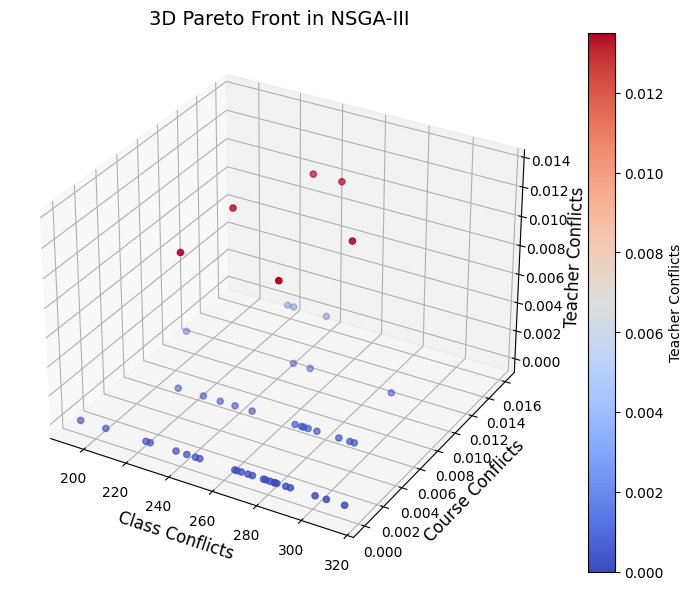

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Fungsi untuk mem-plot Pareto Front dalam 3D
def plot_pareto_fronts_3d(population):
    """3D Scatter Plot of Pareto Front"""
    
    # Ambil nilai fitness untuk setiap individu dalam populasi
    fitness_values = np.array([ind.fitness.values for ind in population])

    # Buat gambar dan subplot 3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot untuk Pareto Front
    scatter = ax.scatter(
        fitness_values[:, 0],  # Class Conflicts
        fitness_values[:, 1],  # Course Conflicts
        fitness_values[:, 2],  # Teacher Conflicts
        c=fitness_values[:, 2], cmap='coolwarm', marker='o'
    )

    # Set label untuk setiap sumbu
    ax.set_xlabel("Class Conflicts", fontsize=12)
    ax.set_ylabel("Course Conflicts", fontsize=12)
    ax.set_zlabel("Teacher Conflicts", fontsize=12)
    ax.set_title("3D Pareto Front in NSGA-III", fontsize=14)

    # Tambahkan grid dan colorbar
    ax.grid(True)
    fig.colorbar(scatter, label="Teacher Conflicts")
    
    # Tampilkan plot
    plt.show()

# Pastikan Anda sudah menjalankan NSGA-III dan memiliki `optimized_population`
# Panggil fungsi untuk menampilkan Pareto Front 3D
plot_pareto_fronts_3d(optimized_population)


In [69]:
# Reverse mapping untuk konversi kembali ke nama asli
reverse_course_map = {v: k for k, v in course_map.items()}
reverse_class_map = {v: k for k, v in class_map.items()}
reverse_lecturer_map = {v: k for k, v in lecturer_map.items()}

In [70]:
def format_schedule(optimized_population, lecture_schedule, num_days, num_slots, num_rooms):
    """Mengubah jadwal terbaik menjadi format tabel yang mudah dibaca dengan nama asli"""
    # Pilih individu dengan total konflik terendah
    best_schedule = min(optimized_population, key=lambda ind: sum(evaluate(ind, courses_df, lecture_schedule)))
    timetable = {}

    # Debugging: Periksa isi best_schedule
    valid_lecture_ids = [lid for lid in best_schedule if lid != 0 and lid in lecture_schedule]
    print(f"Jumlah lecture_id valid di best_schedule: {len(valid_lecture_ids)}")
    print(f"Sampel lecture_id valid: {valid_lecture_ids[:5]}")

    # Bentuk ulang best_schedule menjadi array 3D [days, slots, rooms]
    schedule = np.array(best_schedule).reshape(num_days, num_slots, num_rooms)

    # Definisikan slot waktu sesuai permintaan
    time_ranges = [
        "08:00-08:50", "09:00-09:50", "10:00-10:50", "11:00-11:50",
        "13:00-13:50", "14:00-14:50", "15:00-15:50", "16:00-16:50"
    ]

    # Bangun struktur jadwal
    for day in range(num_days):
        day_name = f"Hari {day + 1}"
        timetable[day_name] = {}
        for room_idx in range(num_rooms):
            room_name = f"Ruang {room_idx + 1}"
            timetable[day_name][room_name] = []
            for slot in range(num_slots):
                lecture_id = schedule[day, slot, room_idx]
                if lecture_id != 0 and lecture_id in lecture_schedule:
                    class_id, course_id, teacher_id = lecture_schedule[lecture_id][0]
                    time_range = time_ranges[slot]
                    # Gunakan reverse mapping untuk nama asli
                    course_name = reverse_course_map.get(course_id, f"Course_{course_id}")
                    class_name = reverse_class_map.get(class_id, f"Class_{class_id}")
                    teacher_name = reverse_lecturer_map.get(teacher_id, f"Teacher_{teacher_id}")
                    timetable[day_name][room_name].append(
                        f"- {time_range} → Mata Kuliah {course_name} (Dosen {teacher_name}, Kelas {class_name})"
                    )

    # Format output
    schedule_output = "\n"
    for day, rooms in timetable.items():
        schedule_output += f"{day}:\n"
        for room, sessions in rooms.items():
            schedule_output += f"  {room}:\n"
            if sessions:
                for session in sessions:
                    schedule_output += f"    {session}\n"
            else:
                schedule_output += f"    - Tidak ada kuliah terjadwal\n"
        schedule_output += "\n"

    return schedule_output

# Format dan cetak jadwal
final_timetable = format_schedule(optimized_population, lecture_schedule, NUM_DAYS, NUM_SLOTS, NUM_ROOMS)
print("\n✅ Jadwal Teroptimasi Final:\n")
print(final_timetable)

Jumlah lecture_id valid di best_schedule: 124
Sampel lecture_id valid: [188, 48, 186, 186, 181]

✅ Jadwal Teroptimasi Final:


Hari 1:
  Ruang 1:
    - 10:00-10:50 → Mata Kuliah 1142202 (Dosen RCH, Kelas Unknown)
    - 16:00-16:50 → Mata Kuliah 14S4092 (Dosen AFS, Kelas Unknown)
  Ruang 2:
    - 08:00-08:50 → Mata Kuliah KUS1201 (Dosen RMS, Kelas Unknown)
    - 10:00-10:50 → Mata Kuliah 1142202 (Dosen RCH, Kelas Unknown)
    - 11:00-11:50 → Mata Kuliah 1331206 (Dosen HER, Kelas Unknown)
  Ruang 3:
    - 08:00-08:50 → Mata Kuliah 21S4201 (Dosen ANA, Kelas Unknown)
  Ruang 4:
    - 11:00-11:50 → Mata Kuliah 11S4094 (Dosen RDS, Kelas Unknown)
  Ruang 5:
    - 08:00-08:50 → Mata Kuliah FIS1201 (Dosen AFS, Kelas Unknown)
  Ruang 6:
    - 08:00-08:50 → Mata Kuliah FIS1201 (Dosen AFS, Kelas Unknown)
    - 11:00-11:50 → Mata Kuliah 1332203 (Dosen FST, Kelas Unknown)
  Ruang 7:
    - Tidak ada kuliah terjadwal
  Ruang 8:
    - 11:00-11:50 → Mata Kuliah  21S4203 (Dosen NSS, Kelas Unknown)
    - 

In [71]:
import numpy as np
from scipy.spatial import ConvexHull

# Function to calculate Hypervolume (HV)
def hypervolume(population):
    """
    Compute the hypervolume of a given population.
    
    Args:
        population: A list of individuals with their fitness values (a list of tuples).
    
    Returns:
        Hypervolume value
    """
    # Extract the fitness values (6 objectives)
    fitness_values = np.array([ind.fitness.values for ind in population])
    
    # Check if fitness_values is empty or invalid
    if len(fitness_values) == 0 or fitness_values.shape[1] != 6:
        print("Error: Invalid or empty fitness values for hypervolume calculation")
        return 0
    
    # Define a reference point: slightly larger than the maximum in each dimension
    reference_point = np.max(fitness_values, axis=0) * 1.2  # 20% larger than max values
    
    # Add small jitter to avoid degenerate dimensions
    jitter = 1e-10 * np.random.rand(*fitness_values.shape)
    fitness_values_jittered = fitness_values + jitter
    
    # Compute the hypervolume using ConvexHull with QJ option
    try:
        hull = ConvexHull(fitness_values_jittered, qhull_options="QJ")
        volume = hull.volume
        return volume
    except Exception as e:
        print(f"Error in hypervolume calculation: {e}")
        return 0

# Function to calculate Inverted Generational Distance (IGD)
def igd(population, reference_front):
    """
    Compute the Inverted Generational Distance (IGD) for a given population.
    
    Args:
        population: A list of individuals with their fitness values (6 objectives).
        reference_front: A list or array of true Pareto front points (6 objectives).
    
    Returns:
        IGD value
    """
    fitness_values = np.array([ind.fitness.values for ind in population])
    reference_front = np.array(reference_front)
    
    # Ensure number of objectives match
    if fitness_values.shape[1] != reference_front.shape[1]:
        raise ValueError(
            f"Number of objectives mismatch: fitness_values has {fitness_values.shape[1]} objectives, "
            f"but reference_front has {reference_front.shape[1]} objectives"
        )
    
    # Check if fitness_values or reference_front is empty
    if len(fitness_values) == 0 or len(reference_front) == 0:
        print("Error: Empty population or reference front")
        return float('inf')
    
    # Compute IGD: minimum distance from each reference front point to the closest solution
    distances = []
    for reference_point in reference_front:
        distances_to_front = np.linalg.norm(fitness_values - reference_point, axis=1)
        distances.append(np.min(distances_to_front))
    
    return np.mean(distances)

# Example usage with optimized_population
# Generate a sample reference front with 6 objectives
# In practice, replace this with the actual true Pareto front if available
reference_front = np.random.rand(10, 6)  # 10 points, each with 6 objectives

# Calculate hypervolume
hv = hypervolume(optimized_population)
print("Hypervolume:", hv)

# Calculate IGD
try:
    igd_value = igd(optimized_population, reference_front)
    print("Inverted Generational Distance (IGD):", igd_value)
except ValueError as e:
    print(f"Error in IGD calculation: {e}")

Hypervolume: 1.0154062891833303e-13
Inverted Generational Distance (IGD): 192.54107010331808
